In [160]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
#from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import joblib
import math

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

sns.set(style="whitegrid", context="notebook")
np.random.seed(42)


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def safe_log10(x):
    return np.log10(np.clip(x, 1e-9, None))

def inv_log10(y):
    return np.power(10.0, y)

def sw_to_logit(sw):
    # hera we are clipping to avoid infinities
    swc = np.clip(sw, 1e-4, 1-1e-4)
    return np.log(swc / (1 - swc))

def logit_to_sw(z):
    return 1.0 / (1.0 + np.exp(-z))


In [161]:
df=pd.read_csv(r"C:\Users\pkpat\Downloads\synthetic_logs_core_minimal.csv")
df.head()

,depth_ft,GR_api,RHOB_gcc,NPHI,DT_usft,RT_ohm_m,SP_mv,PHI_true,PERM_mD,SW_true
0,1000.000000,39.82,2.5995,0.0229,59.434,492.3810,-46.60,0.0296,0.000605,0.5243
1,1001.334223,42.13,2.3954,0.1826,79.375,50.7783,-62.72,0.1654,1.582918,0.2976
2,1002.668446,39.81,2.4780,0.1093,68.501,49.7435,-56.74,0.1061,0.245223,0.4282
3,1004.002668,29.29,2.5228,0.0870,67.568,62.3313,-91.47,0.0898,1.013221,0.4055
4,1005.336891,32.32,2.5478,0.0893,65.092,80.3524,-44.65,0.0718,0.137232,0.4388


In [162]:
#describe thhe Dataaframe we have imported
print("Rows, Columns:", df.shape)
display(df.describe())

#Check if there are any missing values in the dataframe
print("\nMissing values per column:")
print(df.isnull().sum())


Rows, Columns: (1500, 10)


,depth_ft,GR_api,RHOB_gcc,NPHI,DT_usft,RT_ohm_m,SP_mv,PHI_true,PERM_mD,SW_true
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,2000.000000,55.327380,2.554650,0.072493,63.877623,175.600608,-41.380133,0.072622,0.366244,0.546773
std,577.927973,28.341305,0.098832,0.048627,7.112254,214.517768,22.003650,0.044408,1.466000,0.152603
min,1000.000000,7.960000,2.205300,0.000000,50.076000,9.637200,-97.730000,0.020000,0.000100,0.134900
25%,1500.000000,36.485000,2.488750,0.036600,58.645500,45.347050,-57.200000,0.036875,0.001158,0.444025
50%,2000.000000,44.845000,2.560400,0.064450,63.224500,82.495600,-45.300000,0.064650,0.016328,0.516250
75%,2500.000000,64.512500,2.621025,0.099725,68.476500,214.973375,-26.720000,0.098525,0.167392,0.627825
max,3000.000000,160.240000,2.770500,0.279800,89.934000,1636.196300,-0.000000,0.262900,24.326765,0.975000



Missing values per column:
depth_ft    0
GR_api      0
RHOB_gcc    0
NPHI        0
DT_usft     0
RT_ohm_m    0
SP_mv       0
PHI_true    0
PERM_mD     0
SW_true     0
dtype: int64


In [163]:

#Creating List of features and targetsws from dataframe 

features = ["RHOB_gcc", "NPHI", "DT_usft", "GR_api", "RT_ohm_m", "SP_mv"]
targets = ["PHI_true", "PERM_mD", "SW_true"]

# Create feature matrix X and target vectors

X = df[features].copy()
y_phi = df["PHI_true"].values        # porosity fraction
y_logperm = safe_log10(df["PERM_mD"].values)   # log10(permeability)
y_logit_sw = sw_to_logit(df["SW_true"].values)  # logit(sw) 
# Logit functions are used to convert values which are between 0 and 1 to values from - infinty ro infinity so that it is easier for models to get trained 

# Check shapes
print(f"shape of feature matrix:",X.shape)
print (f"Shape of targets:\n{y_phi.shape},\n{y_logperm.shape},\n{ y_logit_sw.shape}")


shape of feature matrix: (1500, 6)
Shape of targets:
(1500,),
(1500,),
(1500,)


In [164]:

# keepin 20% data for testing model when validating and rest 80% data will be used to train the model
# setting random state to 42 is like a seed such that on each run the same set of data is used for traaining and testing
X_train, X_test, yphi_train, yphi_test, ylogperm_train, ylogperm_test, ylogit_sw_train, ylogit_sw_test = train_test_split(
    X, y_phi, y_logperm, y_logit_sw, test_size=0.2, random_state=42
)

# creating scaling tool
scaler = StandardScaler()
# Normalize logs so all features have equal weight
# learns mean & std from training data and applies scaling.
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

# Save scaler for later
joblib.dump(scaler, "scaler_logs.joblib")
print(f"Shapes:\n train data shape: {X_train.shape}\n test data shape: { X_test.shape}")


Shapes:
 train data shape: (1200, 6)
 test data shape: (300, 6)


In [165]:

def evaluate_model(model, X_tr, X_te, y_tr, y_te, inverse_transform=None, verbose=True):
    # Fit model
    model.fit(X_tr, y_tr)
    # Predict on both training and testing data
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)
    # Compute metrics R2 score and RMSE Value for training data and testing data
    r2_tr, r2_te = r2_score(y_tr, y_pred_tr), r2_score(y_te, y_pred_te)
    rmse_tr, rmse_te = rmse(y_tr, y_pred_tr), rmse(y_te, y_pred_te)
    if verbose:
        print(f"Model: {model.__class__.__name__}")
        print(f" Train R²: {r2_tr}  Test R²: {r2_te}")
        print(f" Train RMSE: {rmse_tr}  Test RMSE: {rmse_te}")
    return {
        "model": model,
        "y_pred_tr": y_pred_tr,
        "y_pred_te": y_pred_te,
        "r2_tr": r2_tr,
        "r2_te": r2_te,
        "rmse_tr": rmse_tr,
        "rmse_te": rmse_te
    }
# Functions returns a dictionary with key value pairs  

In [166]:

X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_te_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)#converting np arrays into dataframe

models_phi = [
    RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1),
    XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42, verbosity=0),
    LGBMRegressor(n_estimators=300, max_depth=-1, learning_rate=0.05, random_state=42)
]

results_phi = {}
for m in models_phi:
    res = evaluate_model(m, X_tr_scaled, X_te_scaled, yphi_train, yphi_test)
    results_phi[res["model"].__class__.__name__] = res # A dictionary having model name as key and the dictionary retuned as value


Model: RandomForestRegressor
 Train R²: 0.9976257119429673  Test R²: 0.9851287261373401
 Train RMSE: 0.0021506482875325444  Test RMSE: 0.005536740577195822
Model: XGBRegressor
 Train R²: 0.9984997610244609  Test R²: 0.9826034595892578
 Train RMSE: 0.0017095543430562206  Test RMSE: 0.005988410105952103
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 6
[LightGBM] [Info] Start training from score 0.072558
Model: LGBMRegressor
 Train R²: 0.9969496597466586  Test R²: 0.9792999124180128
 Train RMSE: 0.002437680771153731  Test RMSE: 0.006532300890240622


In [167]:
def get_r2(k):
    return results_phi[k]["r2_te"]
best_phi_name = max(results_phi, key=get_r2)

best_phi = results_phi[best_phi_name]["model"]
print("Best porosity model:", best_phi_name, "Test R²:", results_phi[best_phi_name]["r2_te"])


Best porosity model: RandomForestRegressor Test R²: 0.9851287261373401


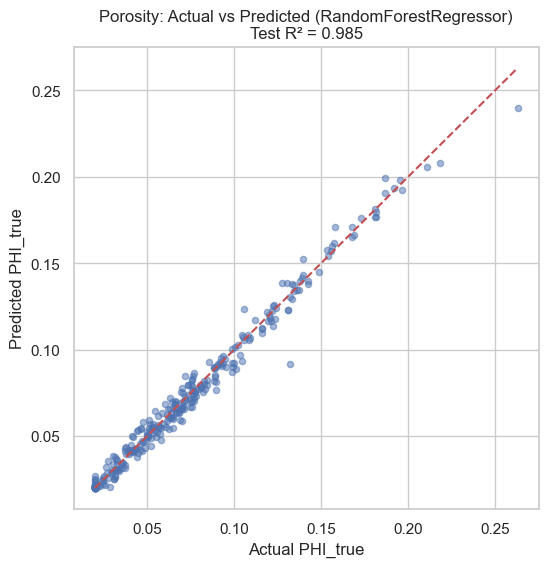

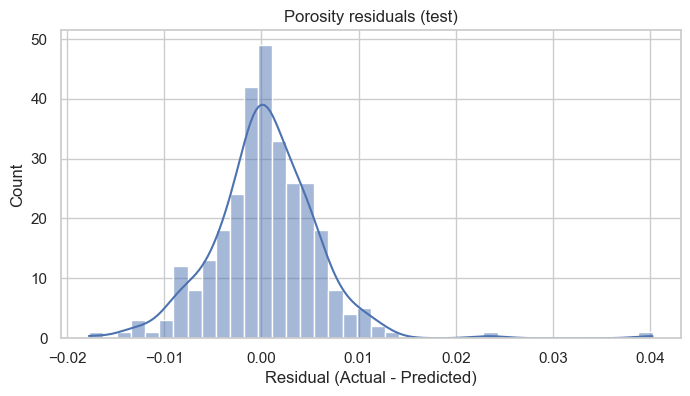

In [168]:

# Predictions on test set
yphi_pred_test = results_phi[best_phi_name]["y_pred_te"]
yphi_pred_train = results_phi[best_phi_name]["y_pred_tr"]

plt.figure(figsize=(6,6))
plt.scatter(yphi_test, yphi_pred_test, alpha=0.5, s=20)
plt.plot([yphi_test.min(), yphi_test.max()], [yphi_test.min(), yphi_test.max()], 'r--')
plt.xlabel("Actual PHI_true")
plt.ylabel("Predicted PHI_true")
plt.title(f"Porosity: Actual vs Predicted ({best_phi_name})\nTest R² = {results_phi[best_phi_name]['r2_te']:.3f}")
plt.grid(True)
plt.show()

# Residuals
residuals = yphi_test - yphi_pred_test
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True, bins=40)
plt.title("Porosity residuals (test)")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()
#Here the the curve maxima lies around zero this siginifies good model


In [169]:
X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_te_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)#converting np arrays into dataframe

models_perm = [
    RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1),
    XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.03, random_state=42, verbosity=0),
    LGBMRegressor(n_estimators=400, max_depth=-1, learning_rate=0.03, random_state=42)
]

results_perm = {}
for m in models_perm:
    res = evaluate_model(m, X_tr_scaled, X_te_scaled, ylogperm_train, ylogperm_test)
    results_perm[res["model"].__class__.__name__] = res

best_perm_name = max(results_perm, key=lambda k: results_perm[k]["r2_te"])
print("Best permeability model:", best_perm_name, "Test R²:", results_perm[best_perm_name]["r2_te"])


Model: RandomForestRegressor
 Train R²: 0.9889730262282203  Test R²: 0.9098370137978715
 Train RMSE: 0.14034139549797375  Test RMSE: 0.3972829944059204
Model: XGBRegressor
 Train R²: 0.9912253083579884  Test R²: 0.9093644389894489
 Train RMSE: 0.12519112774090888  Test RMSE: 0.3983227812155419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 6
[LightGBM] [Info] Start training from score -1.851602
Model: LGBMRegressor
 Train R²: 0.985646189864189  Test R²: 0.9052874647092415
 Train RMSE: 0.16011839145162793  Test RMSE: 0.407182929937012
Best permeability model: RandomForestRegressor Test R²: 0.9098370137978715


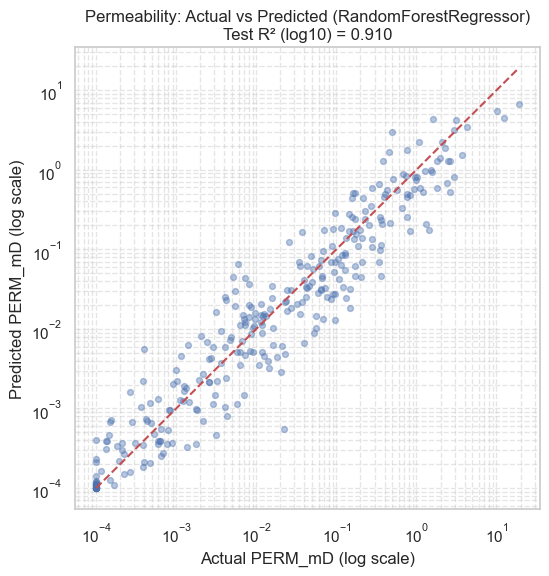

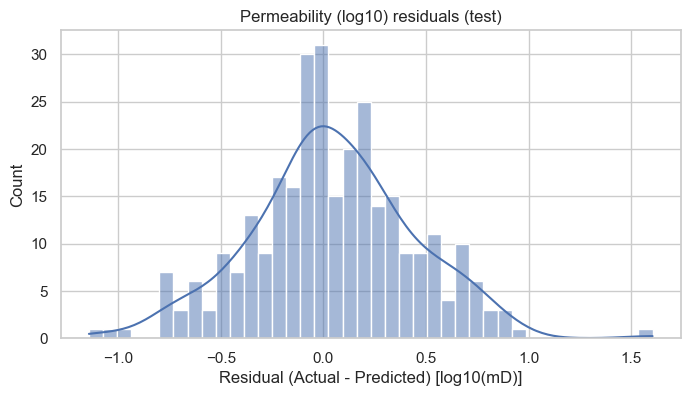

In [170]:

ylogperm_pred_test = results_perm[best_perm_name]["y_pred_te"]
# convert to permeability in mD
perm_pred_test_mD = inv_log10(ylogperm_pred_test)
perm_test_mD = inv_log10(ylogperm_test)

plt.figure(figsize=(6,6))
plt.scatter(perm_test_mD, perm_pred_test_mD, alpha=0.4, s=18)
plt.plot([perm_test_mD.min(), perm_test_mD.max()], [perm_test_mD.min(), perm_test_mD.max()], 'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Actual PERM_mD (log scale)")
plt.ylabel("Predicted PERM_mD (log scale)")
plt.title(f"Permeability: Actual vs Predicted ({best_perm_name})\nTest R² (log10) = {results_perm[best_perm_name]['r2_te']:.3f}")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# Residuals in log space
res_perm_log = ylogperm_test - ylogperm_pred_test
plt.figure(figsize=(8,4))
sns.histplot(res_perm_log, kde=True, bins=40)
plt.title("Permeability (log10) residuals (test)")
plt.xlabel("Residual (Actual - Predicted) [log10(mD)]")
plt.show()


In [171]:
X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_te_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)#converting np arrays into dataframe

models_sw = [
    RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1),
    XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.03, random_state=42, verbosity=0),
    LGBMRegressor(n_estimators=400, max_depth=-1, learning_rate=0.03, random_state=42)
]

results_sw = {}
for m in models_sw:
    res = evaluate_model(m, X_tr_scaled, X_te_scaled, ylogit_sw_train, ylogit_sw_test)
    results_sw[res["model"].__class__.__name__] = res

best_sw_name = max(results_sw, key=lambda k: results_sw[k]["r2_te"])
print("Best SW model:", best_sw_name, "Test R²:", results_sw[best_sw_name]["r2_te"])


Model: RandomForestRegressor
 Train R²: 0.9843631536277127  Test R²: 0.8931483160324273
 Train RMSE: 0.09111405063145622  Test RMSE: 0.2180195109983921
Model: XGBRegressor
 Train R²: 0.989534524257533  Test R²: 0.8987078423669744
 Train RMSE: 0.07454014914641975  Test RMSE: 0.21227193891528862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 6
[LightGBM] [Info] Start training from score 0.242043
Model: LGBMRegressor
 Train R²: 0.9780195452289124  Test R²: 0.9003959847000894
 Train RMSE: 0.10802620178603177  Test RMSE: 0.2104956371794381
Best SW model: LGBMRegressor Test R²: 0.9003959847000894


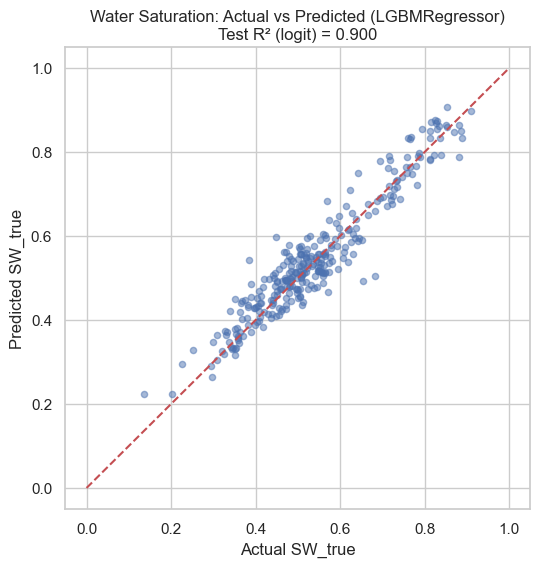

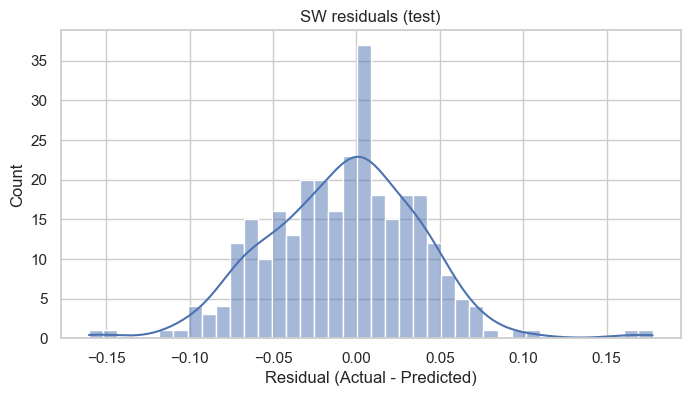

In [172]:

ylogit_sw_pred_test = results_sw[best_sw_name]["y_pred_te"]
sw_pred_test = logit_to_sw(ylogit_sw_pred_test)
sw_test = logit_to_sw(ylogit_sw_test)

plt.figure(figsize=(6,6))
plt.scatter(sw_test, sw_pred_test, alpha=0.5, s=20)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("Actual SW_true")
plt.ylabel("Predicted SW_true")
plt.title(f"Water Saturation: Actual vs Predicted ({best_sw_name})\nTest R² (logit) = {results_sw[best_sw_name]['r2_te']:.3f}")
plt.grid(True)
plt.show()

# Residuals
res_sw = sw_test - sw_pred_test
plt.figure(figsize=(8,4))
sns.histplot(res_sw, kde=True, bins=40)
plt.title("SW residuals (test)")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()


In [173]:

import pandas as pd

summary = []
summary.append({
    "target": "PHI_true",
    "model": best_phi_name,
    "train_R2": results_phi[best_phi_name]["r2_tr"],
    "test_R2": results_phi[best_phi_name]["r2_te"],
    "train_RMSE": results_phi[best_phi_name]["rmse_tr"],
    "test_RMSE": results_phi[best_phi_name]["rmse_te"]
})
summary.append({
    "target": "log10(PERM_mD)",
    "model": best_perm_name,
    "train_R2": results_perm[best_perm_name]["r2_tr"],
    "test_R2": results_perm[best_perm_name]["r2_te"],
    "train_RMSE": results_perm[best_perm_name]["rmse_tr"],
    "test_RMSE": results_perm[best_perm_name]["rmse_te"]
})
summary.append({
    "target": "logit(SW)",
    "model": best_sw_name,
    "train_R2": results_sw[best_sw_name]["r2_tr"],
    "test_R2": results_sw[best_sw_name]["r2_te"],
    "train_RMSE": results_sw[best_sw_name]["rmse_tr"],
    "test_RMSE": results_sw[best_sw_name]["rmse_te"]
})

display(pd.DataFrame(summary).round(4))


,target,model,train_R2,test_R2,train_RMSE,test_RMSE
0,PHI_true,RandomForestRegressor,0.9976,0.9851,0.0022,0.0055
1,log10(PERM_mD),RandomForestRegressor,0.9890,0.9098,0.1403,0.3973
2,logit(SW),LGBMRegressor,0.9780,0.9004,0.1080,0.2105
